# DACL

In [4]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.init as init


In [5]:
class FERDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        self.data = []

        for label, emotion in enumerate(self.classes):
            emotion_dir = os.path.join(root_dir, emotion)
            for filename in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, filename)
                if os.path.exists(img_path):  
                    self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]

        for _ in range(3):  
            try:
                image = Image.open(img_path).convert('L')  
                if self.transform:
                    image = self.transform(image)
                return image, label
            except FileNotFoundError:
                time.sleep(1) 
        raise FileNotFoundError(f"Failed to open {img_path} after multiple attempts.")

transform = transforms.Compose([
    transforms.Grayscale(),  
    transforms.Resize((230, 230)),  
    transforms.RandomRotation(15), 
    transforms.RandomCrop(224, padding=8),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
])

train_dataset = FERDataset('C:/Users/user/Desktop/DLProject/FER-2013/train', transform=transform)
test_dataset = FERDataset('C:/Users/user/Desktop/DLProject/FER-2013/test', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0) 

In [6]:
class AttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, height, width = x.size()
        
        # Generate attention weights
        q = self.conv1(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        k = self.conv1(x).view(batch_size, -1, height * width)
        v = self.conv2(x).view(batch_size, C, height * width)

        attn_weights = self.softmax(torch.bmm(q, k))
        attn_output = torch.bmm(attn_weights, v.transpose(1, 2)).view(batch_size, C, height, width)

        return x + attn_output

class DACLModel(nn.Module):
    def __init__(self, num_classes):
        super(DACLModel, self).__init__()
        
        # Load the pre-trained ResNet18 model
        self.base_model = models.resnet18(pretrained=True)
        
        # Modify the first layer to accept 1-channel (grayscale) input
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the final FC layer
        self.base_model.fc = nn.Identity()  
        
        self.attention = AttentionModule(in_channels=512)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), 512, 1, 1)  # Change shape to [batch_size, 512, 1, 1]
        x = self.attention(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DACLModel(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30], gamma=0.1)

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    scheduler.step()

    # Print training accuracy and loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss/len(train_loader):.4f}, Training Accuracy: {100.*correct/total:.2f}%")

Epoch 1/1, Training Loss: 1.9158, Training Accuracy: 22.85%


Accuracy: 29.24212872666481%
Confusion Matrix:


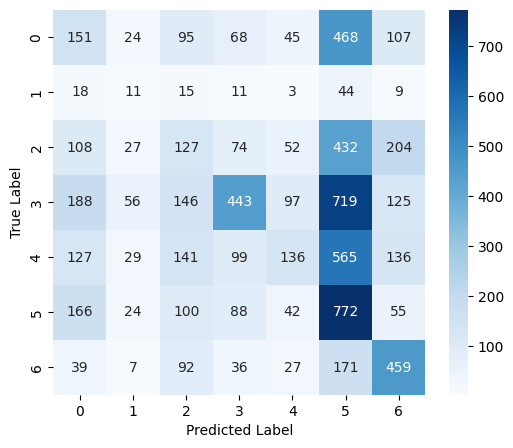

Precision: 0.3341624690934372
Recall: 0.29242128726664807
F1 Score: 0.27388508589929617
Class 0 AUC: 0.5883015090387933
Class 1 AUC: 0.7279271630481479
Class 2 AUC: 0.5537494985476925
Class 3 AUC: 0.6953609460443931
Class 4 AUC: 0.5988716519433002
Class 5 AUC: 0.637751138899266
Class 6 AUC: 0.8401547335533033


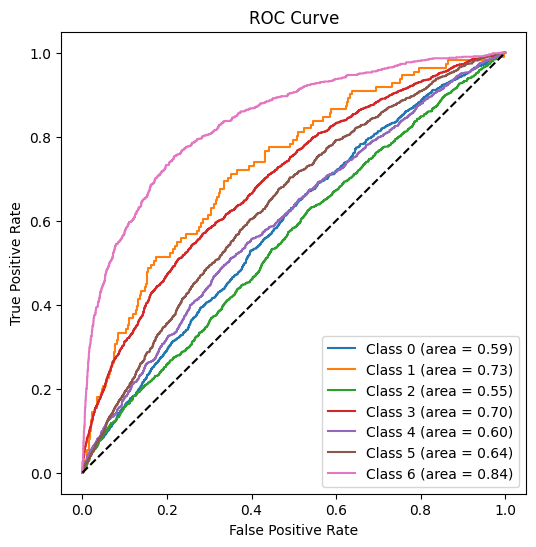

In [7]:
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []
all_outputs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Appending labels and predictions for further evaluation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())

print(f"Accuracy: {100 * correct / total}%")

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

num_classes = 7
all_labels_bin = label_binarize(all_labels, classes=[i for i in range(num_classes)])
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_outputs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(num_classes):
    print(f"Class {i} AUC: {roc_auc[i]}")

plt.figure(figsize=(6, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show() 